A fully automated deep learning-based network for detecting COVID-19
from a new and large lung CT scan dataset: https://reader.elsevier.com/reader/sd/pii/S1746809421001853?token=C52CDDCCB7867247F5B9B954D8DCDF59EAAE826AD50D96EDA50699F3EE518DCFB38D56A7F3937375D1233F1D16171BF7&originRegion=eu-west-1&originCreation=20230216091455

In [5]:
!mkdir ~/.kaggle
!touch ~/.kaggle/kaggle.json

api_token = {"username":"username","key":"key"}

import json

with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
     

In [6]:
!kaggle datasets download -d masoudnickparvar/brain-tumor-mri-dataset

100% 149M/149M [00:31<00:00, 4.98MB/s]
100% 149M/149M [00:31<00:00, 5.02MB/s]


In [7]:
!unzip -qq brain-tumor-mri-dataset.zip

In [8]:
!ls -al Training

total 220
drwxr-xr-x 6 root root  4096 Feb 16 08:18 .
drwxr-xr-x 1 root root  4096 Feb 16 08:18 ..
drwxr-xr-x 2 root root 45056 Feb 16 08:18 glioma
drwxr-xr-x 2 root root 45056 Feb 16 08:18 meningioma
drwxr-xr-x 2 root root 69632 Feb 16 08:18 notumor
drwxr-xr-x 2 root root 57344 Feb 16 08:18 pituitary


In [9]:
!ls -al Testing

total 64
drwxr-xr-x 6 root root  4096 Feb 16 08:18 .
drwxr-xr-x 1 root root  4096 Feb 16 08:18 ..
drwxr-xr-x 2 root root 12288 Feb 16 08:18 glioma
drwxr-xr-x 2 root root 12288 Feb 16 08:18 meningioma
drwxr-xr-x 2 root root 20480 Feb 16 08:18 notumor
drwxr-xr-x 2 root root 12288 Feb 16 08:18 pituitary


In [10]:
!pip install git+https://github.com/mr7495/RetinaNet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/mr7495/RetinaNet to /tmp/pip-req-build-9_8lagnk
  Running command git clone --filter=blob:none --quiet https://github.com/mr7495/RetinaNet /tmp/pip-req-build-9_8lagnk
  Resolved https://github.com/mr7495/RetinaNet to commit 6a85690f62f9e504db99dcd04391fa790690c498
  Running command git submodule update --init --recursive -q
  Preparing metadata (setup.py) ... done
  Preparing metadata (setup.py) ... done
  Created wheel for keras-retinanet: filename=keras_retinanet-0.5.1-cp38-cp38-linux_x86_64.whl size=197743 sha256=ffa660a4818eddccabae0aca2576e9a0d9394ceb57b52f5666ec1bc0a2e84efb
  Stored in directory: /tmp/pip-ephem-wheel-cache-makkzhgh/wheels/4f/8a/8d/f8525949b0585b0f5ec954cae26151f3a6d3bd87a714c1bb34
  Created wheel for keras-resnet: filename=keras_resnet-0.1.0-py2.py3-none-any.whl size=13343 sha256=f112a084203c8257559751afbfbeb8202cdb58c46e1a290d057ddb97cd

In [1]:
import keras
import numpy as np
import cv2
import os
import random
import shutil
import pandas as pd
import csv

from keras import optimizers
from keras.models import Sequential,Model
from keras.layers import Dropout, Flatten, Dense,Input

from keras.callbacks import ModelCheckpoint
from keras.applications.imagenet_utils import preprocess_input

from keras.initializers import RandomNormal

import io
from PIL import Image as pil_image
from keras_retinanet import layers
import keras.backend as k
import keras_retinanet

In [2]:
import tensorflow as tf

In [3]:
tf.keras.utils.set_random_seed(1234)

In [4]:
imagePaths = "Training"
test_path="Testing"

In [5]:
batch_size=16
img_height = 224
img_width = 224

In [6]:
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths,
  #color_mode='grayscale',
  validation_split=0.15,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 5712 files belonging to 4 classes.
Using 4856 files for training.


In [7]:
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
  imagePaths, 
  #color_mode='grayscale',
  validation_split=0.15,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)   

Found 5712 files belonging to 4 classes.
Using 856 files for validation.


In [8]:
test_ds = tf.keras.preprocessing.image_dataset_from_directory(
  test_path,
  #seed=123,
  image_size=(img_height, img_width),
  #label_mode="categorical",
  batch_size=batch_size)

Found 1311 files belonging to 4 classes.


In [9]:
import matplotlib.pyplot as plt

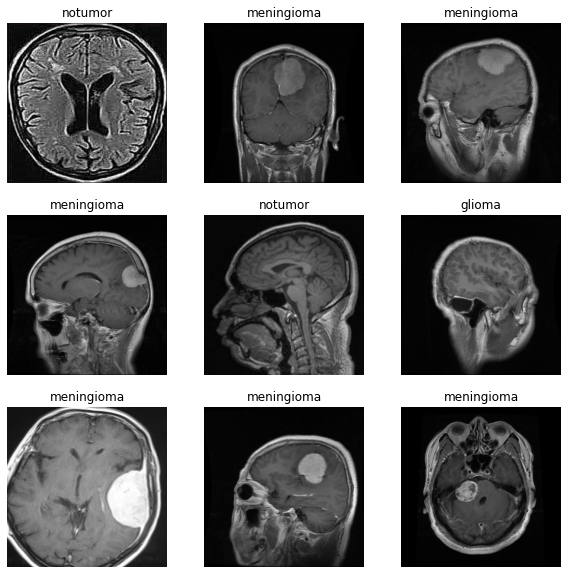

In [10]:
class_names = train_ds.class_names
plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [10]:
data_augmentation= Sequential([
                               tf.keras.layers.RandomFlip("horizontal"),
                               tf.keras.layers.RandomBrightness(factor=0.1, value_range=(0, 255), seed=123)
])

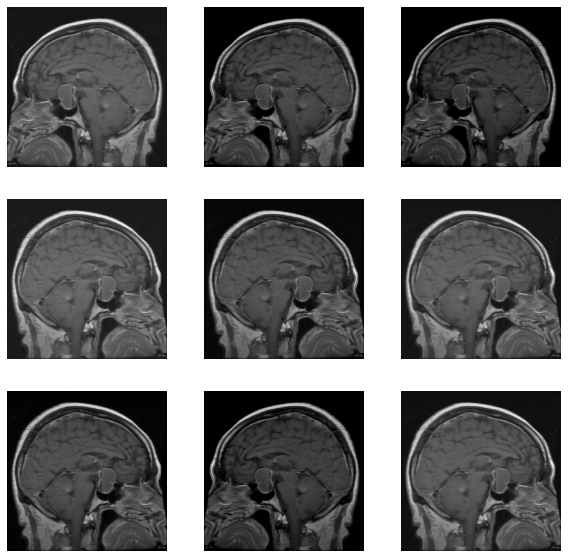

In [23]:
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")

In [11]:
num_of_classes=4
feature_size=128

In [18]:
from keras.applications.resnet_v2 import ResNet50V2

In [19]:
inputs= keras.Input(shape=(img_height, img_width,3))
x = data_augmentation(inputs)
x = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(x)


base_model = ResNet50V2(weights='imagenet', include_top=False, input_tensor=x) #Load the ResNet50V2 model without weights


#Create Feature Pyramid Network (FPN)
# We used some help for writing the Pyramid from the written code on https://github.com/fizyr/keras-retinanet/blob/master/keras_retinanet/models/retinanet.py

layer_names = ["conv4_block1_preact_relu", "conv5_block1_preact_relu", "post_relu"] #Layers of ResNet50V2 with different scale features 
layer_outputs = [base_model.get_layer(name).output for name in layer_names]
C3, C4, C5=layer_outputs 


P5           = tf.keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C5_reduced')(C5)
P5_upsampled = layers.UpsampleLike(name='P5_upsampled')([P5, C4])
P5           = tf.keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, padding='same', name='P5')(P5)

# Concatenate P5 elementwise to C4
P4           = tf.keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C4_reduced')(C4)
P4           = tf.keras.layers.Concatenate(axis=3)([P5_upsampled, P4])
P4_upsampled = layers.UpsampleLike(name='P4_upsampled')([P4, C3])
P4           = tf.keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P4')(P4)

# Concatenate P4 elementwise to C3
P3 = tf.keras.layers.Conv2D(feature_size, kernel_size=1, strides=1, padding='same', name='C3_reduced')(C3)
P3 = tf.keras.layers.Concatenate(axis=3)([P4_upsampled, P3])
P3 = tf.keras.layers.Conv2D(feature_size, kernel_size=3, strides=1, name='P3')(P3)

# "P6 is obtained via a 3x3 stride-2 conv on C5"
P6 = tf.keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P6')(C5)

# "P7 is computed by applying ReLU followed by a 3x3 stride-2 conv on P6"
P7 = tf.keras.layers.Activation('relu', name='C6_relu')(P6)
P7 = tf.keras.layers.Conv2D(feature_size, kernel_size=3, strides=2, padding='same', name='P7')(P7)

# Run classification for each of the generated features from the pyramid
feature1 = Flatten()(P3)
dp1 = Dropout(0.5)(feature1)
preds1 = Dense(num_of_classes, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp1)




feature2 = Flatten()(P4)
dp2 = Dropout(0.5)(feature2)
preds2 = Dense(num_of_classes, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp2)



feature3 = Flatten()(P5)
dp3= Dropout(0.5)(feature3)
preds3 = Dense(num_of_classes, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp3)



feature4 = Flatten()(P6)
dp4 = Dropout(0.5)(feature4)
preds4 = Dense(num_of_classes, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp4)



feature5 = Flatten()(P7)
dp5 = Dropout(0.5)(feature5)
preds5 = Dense(num_of_classes, activation='relu',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(dp5)



concat=tf.keras.layers.Concatenate(axis=1)([preds1,preds2,preds3,preds4,preds5]) #Concatenate the predictions(Classification results) of each of the pyramid features 
out=tf.keras.layers.Dense(num_of_classes,activation='softmax',kernel_initializer=RandomNormal(mean=0.0, stddev=0.001))(concat) #Final Classification

model = Model(inputs=inputs, outputs=out) #Create the Training Model


94668760/94668760 [==============================] - 1s 0us/step


In [20]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 sequential (Sequential)        (None, 224, 224, 3)  0           ['input_6[0][0]']                
                                                                                                  
 rescaling_3 (Rescaling)        (None, 224, 224, 3)  0           ['sequential[3][0]']             
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['rescaling_3[0][0]']      

In [22]:
def get_early_stopping():
    
    return tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [23]:
def get_checkpoint_best_only():
    
    checkpoint_best_path= 'checkpoints_best_only'
    checkpoint_best= ModelCheckpoint(filepath=checkpoint_best_path,
                           frequency='epoch',
                           save_weights_only=False,
                           monitor='val_accuracy',
                           save_best_only=True,
                           verbose=1)
    return checkpoint_best

In [24]:
import datetime

In [25]:
checkpoint_best_only = get_checkpoint_best_only()
early_stopping = get_early_stopping()
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

#callbacks = [checkpoint_best_only, early_stopping, tensorboard_callback]
callbacks = [checkpoint_best_only, tensorboard_callback, early_stopping]

In [26]:
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import MultiLabelBinarizer


def generate_class_weights(class_series, multi_class=True, one_hot_encoded=False):
  """
  Method to generate class weights given a set of multi-class or multi-label labels, both one-hot-encoded or not.
  Some examples of different formats of class_series and their outputs are:
    - generate_class_weights(['mango', 'lemon', 'banana', 'mango'], multi_class=True, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 1.3333333333333333, 'mango': 0.6666666666666666}
    - generate_class_weights([[1, 0, 0], [0, 1, 0], [0, 0, 1], [1, 0, 0]], multi_class=True, one_hot_encoded=True)
    {0: 0.6666666666666666, 1: 1.3333333333333333, 2: 1.3333333333333333}
    - generate_class_weights([['mango', 'lemon'], ['mango'], ['lemon', 'banana'], ['lemon']], multi_class=False, one_hot_encoded=False)
    {'banana': 1.3333333333333333, 'lemon': 0.4444444444444444, 'mango': 0.6666666666666666}
    - generate_class_weights([[0, 1, 1], [0, 0, 1], [1, 1, 0], [0, 1, 0]], multi_class=False, one_hot_encoded=True)
    {0: 1.3333333333333333, 1: 0.4444444444444444, 2: 0.6666666666666666}
  The output is a dictionary in the format { class_label: class_weight }. In case the input is one hot encoded, the class_label would be index
  of appareance of the label when the dataset was processed. 
  In multi_class this is np.unique(class_series) and in multi-label np.unique(np.concatenate(class_series)).
  Author: Angel Igareta (angel@igareta.com)
  """
  if multi_class:
    # If class is one hot encoded, transform to categorical labels to use compute_class_weight   
    if one_hot_encoded:
      class_series = np.argmax(class_series, axis=1)
  
    # Compute class weights with sklearn method
    class_labels = np.unique(class_series)
    class_weights = compute_class_weight(class_weight='balanced', classes=class_labels, y=class_series)
    return dict(zip(class_labels, class_weights))
  else:
    # It is neccessary that the multi-label values are one-hot encoded
    mlb = None
    if not one_hot_encoded:
      mlb = MultiLabelBinarizer()
      class_series = mlb.fit_transform(class_series)

    n_samples = len(class_series)
    n_classes = len(class_series[0])

    # Count each class frequency
    class_count = [0] * n_classes
    for classes in class_series:
        for index in range(n_classes):
            if classes[index] != 0:
                class_count[index] += 1
    
    # Compute class weights using balanced method
    class_weights = [n_samples / (n_classes * freq) if freq > 0 else 1 for freq in class_count]
    class_labels = range(len(class_weights)) if mlb is None else mlb.classes_
    return dict(zip(class_labels, class_weights))

In [27]:
y_train= tf.concat([y for x, y in train_ds], axis=0)

In [28]:
class_weights = generate_class_weights(y_train.numpy())

In [29]:
class_weights

{0: 1.0639789658194567,
 1: 1.0848972296693475,
 2: 0.8992592592592593,
 3: 0.9743178170144462}

In [30]:
model.compile(
  optimizer='adam',
  loss=tf.losses.SparseCategoricalCrossentropy(),
  metrics=['accuracy'])

In [31]:
history = model.fit(train_ds, validation_data=val_ds, batch_size=batch_size, epochs=50, class_weight=class_weights, callbacks=callbacks)

Epoch 1/50


304/304 [==============================] - ETA: 0s - loss: 0.6842 - accuracy: 0.7488
Epoch 1: val_accuracy improved from -inf to 0.32243, saving model to checkpoints_best_only


304/304 [==============================] - 156s 372ms/step - loss: 0.6842 - accuracy: 0.7488 - val_loss: 9.7327 - val_accuracy: 0.3224
Epoch 2/50
304/304 [==============================] - ETA: 0s - loss: 0.4340 - accuracy: 0.8540
Epoch 2: val_accuracy improved from 0.32243 to 0.45678, saving model to checkpoints_best_only


304/304 [==============================] - 113s 372ms/step - loss: 0.4340 - accuracy: 0.8540 - val_loss: 1.8853 - val_accuracy: 0.4568
Epoch 3/50
304/304 [==============================] - ETA: 0s - loss: 0.3370 - accuracy: 0.8880
Epoch 3: val_accuracy improved from 0.45678 to 0.54556, saving model to checkpoints_best_only


304/304 [==============================] - 106s 348ms/step - loss: 0.3370 - accuracy: 0.8880 - val_loss: 1.7718 - val_accuracy: 0.5456
Epoch 4/50
304/304 [==============================] - ETA: 0s - loss: 0.3121 - accuracy: 0.8921
Epoch 4: val_accuracy improved from 0.54556 to 0.67874, saving model to checkpoints_best_only


304/304 [==============================] - 107s 351ms/step - loss: 0.3121 - accuracy: 0.8921 - val_loss: 2.5069 - val_accuracy: 0.6787
Epoch 5/50
304/304 [==============================] - ETA: 0s - loss: 0.3068 - accuracy: 0.8987
Epoch 5: val_accuracy improved from 0.67874 to 0.90187, saving model to checkpoints_best_only


304/304 [==============================] - 106s 348ms/step - loss: 0.3068 - accuracy: 0.8987 - val_loss: 0.7514 - val_accuracy: 0.9019
Epoch 6/50
304/304 [==============================] - ETA: 0s - loss: 0.3202 - accuracy: 0.9016
Epoch 6: val_accuracy did not improve from 0.90187
304/304 [==============================] - 76s 248ms/step - loss: 0.3202 - accuracy: 0.9016 - val_loss: 65.1530 - val_accuracy: 0.3516
Epoch 7/50
304/304 [==============================] - ETA: 0s - loss: 0.2762 - accuracy: 0.9203
Epoch 7: val_accuracy did not improve from 0.90187
304/304 [==============================] - 75s 247ms/step - loss: 0.2762 - accuracy: 0.9203 - val_loss: 2.3487 - val_accuracy: 0.7290
Epoch 8/50
304/304 [==============================] - ETA: 0s - loss: 0.3495 - accuracy: 0.9022
Epoch 8: val_accuracy did not improve from 0.90187
304/304 [==============================] - 75s 246ms/step - loss: 0.3495 - accuracy: 0.9022 - val_loss: 1.7762 - val_accuracy: 0.7488
Epoch 9/50
304/304 [=

In [32]:
the_best_model=model

the_best_model.load_weights("checkpoints_best_only")

In [33]:
model.evaluate(test_ds)

82/82 [==============================] - 6s 68ms/step - loss: 1.2691 - accuracy: 0.8604


[1.2691336870193481, 0.8604118824005127]

In [34]:
from sklearn.metrics import classification_report, confusion_matrix

In [ ]:
predictions = np.array([])
labels =  np.array([])
for x, y in test_ds:
  Y_pred=model.predict(x)
  y_prediction = np.argmax(Y_pred, axis=1)
  predictions = np.concatenate([predictions, y_prediction])
  labels = np.concatenate([labels, y.numpy()])

In [36]:
print('Confusion Matrix')
print(confusion_matrix(y_true=labels, y_pred=predictions))

Confusion Matrix
[[250  36   8   6]
 [ 17 185  90  14]
 [  0   1 401   3]
 [  1   5   2 292]]


In [37]:
classes=['glioma','meningioma', 'notumor','pituitary']

In [38]:
import itertools

[[250  36   8   6]
 [ 17 185  90  14]
 [  0   1 401   3]
 [  1   5   2 292]]


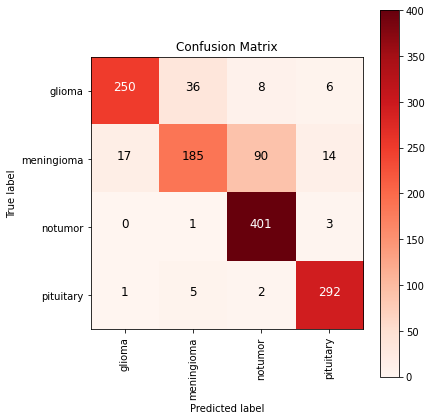

In [39]:
def plot_confusion_matrix(cm, classes,
                          normalize = False,
                          title = 'Confusion Matrix',
                          cmap = plt.cm.Reds):
    
    plt.figure(figsize = (6,6))
    plt.imshow(cm, interpolation = 'nearest', cmap = cmap)
    plt.title(title)
    plt.colorbar()
    plt.grid(False)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation = 90)
    plt.yticks(tick_marks, classes)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis = 1)[:, np.newaxis]

    thresh = cm.max() / 2.
    cm = np.round(cm,2)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 fontsize = 12,
                 horizontalalignment = "center",
                 color = "white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.show()
#get confusion matrix
cm = confusion_matrix(labels, predictions)
print(cm)

#plot
plot_confusion_matrix(cm, classes, normalize=False)

In [40]:
print('Classification Report')
target_names = classes
print(classification_report(y_true=labels, y_pred=predictions, target_names=target_names))

Classification Report
              precision    recall  f1-score   support

      glioma       0.93      0.83      0.88       300
  meningioma       0.81      0.60      0.69       306
     notumor       0.80      0.99      0.89       405
   pituitary       0.93      0.97      0.95       300

    accuracy                           0.86      1311
   macro avg       0.87      0.85      0.85      1311
weighted avg       0.86      0.86      0.85      1311

